In [127]:
import torch
import torch.nn as nn
import torchvision

In [93]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-06-14 16:19:30--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py.2'

     0K ...                                                   100% 27.9M=0s

2024-06-14 16:19:30 (27.9 MB/s) - 'engine.py.2' saved [4063/4063]

--2024-06-14 16:19:30--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

In [16]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 6.8 MB/s eta 0:00:00a 0:00:01


In [3]:
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data > /dev/null
!cd data && unzip PennFudanPed.zip > /dev/null

--2024-06-14 15:03:50--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: 'data/PennFudanPed.zip'

PennFudanPed.zip    100%[===================>]  51.23M  7.13MB/s    in 10m 5s  

2024-06-14 15:13:56 (86.8 KB/s) - 'data/PennFudanPed.zip' saved [53723336/53723336]



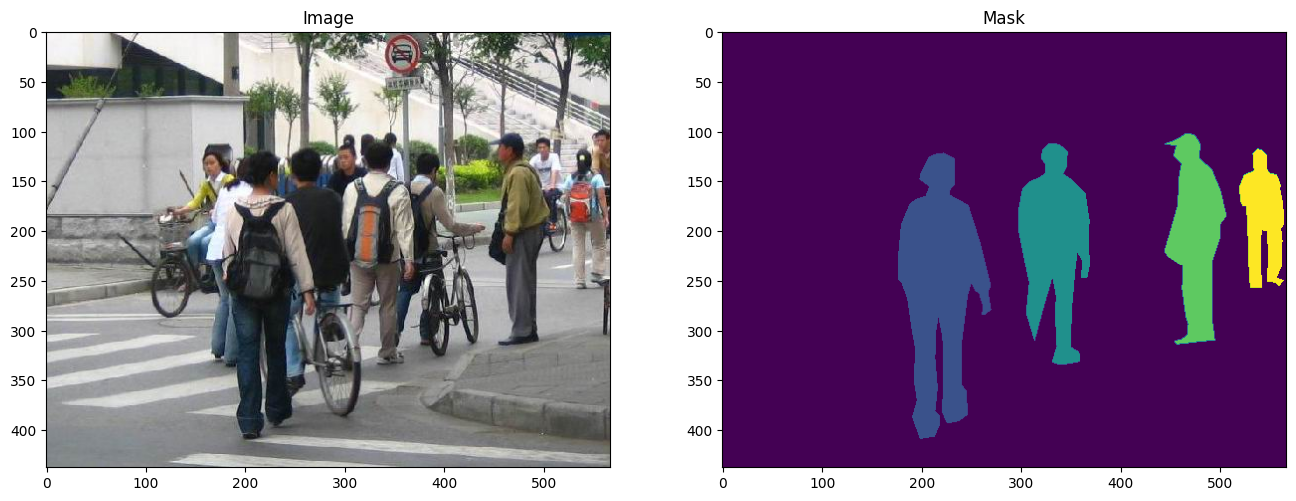

In [ ]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [69]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = read_image(img_path)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [119]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.Resize((224, 224)))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [290]:
class FCN(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(3,3), stride=2, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.leaky_relu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=2, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.leaky_relu2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3,3), stride=2, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(256)
        self.leaky_relu3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=(3,3), stride=2, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(512)
        self.leaky_relu4 = nn.LeakyReLU(0.2)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=(3,3), stride=2, padding=1)
        self.batch_norm5 = nn.BatchNorm2d(1024)
        self.leaky_relu5 = nn.LeakyReLU(0.2)
        
        self.conv_attention = nn.Sequential(
            nn.LazyConv2d(64, kernel_size=(5,5), stride=2, padding=2),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=2, padding=1),
            nn.Conv2d(128, 256, kernel_size=(3,3), stride=2, padding=1),
            nn.Conv2d(256, 256, kernel_size=(3,3), stride=2, padding=1),
            nn.Conv2d(256, 128, kernel_size=(3,3), stride=2, padding=1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.Sigmoid()
        )
        
        self.calc_weights = nn.Sequential(
            nn.Linear(128*5, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 5),
            nn.Softmax()
        )
        
        self.t_conv5 = nn.ConvTranspose2d(1024, 64, kernel_size=(3,3), stride=32, padding=1, output_padding=31)
        self.t_conv4 = nn.ConvTranspose2d(512, 64, kernel_size=(3,3), stride=16, padding=1, output_padding=15)
        self.t_conv3 = nn.ConvTranspose2d(256, 64, kernel_size=(3,3), stride=8, padding=1, output_padding=7)
        self.t_conv2 = nn.ConvTranspose2d(128, 64, kernel_size=(3,3), stride=4, padding=1, output_padding=3)
        self.t_conv1 = nn.ConvTranspose2d(64, 64, kernel_size=(3,3), stride=2, padding=1, output_padding=1)
        
        self.final_conv1 = nn.Conv2d(64, 256, kernel_size=(5,5), stride=1, padding=2)
        self.final_conv2 = nn.Conv2d(256, 64, kernel_size=(5,5), stride=1, padding=2)
        self.final_conv3 = nn.Conv2d(64, out_channels, kernel_size=(3,3), stride=1, padding=1)
        
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
#         print(x.shape)
        x1 = self.leaky_relu1(self.batch_norm1(self.conv1(x)))
#         print(x1.shape)
        x2 = self.leaky_relu2(self.batch_norm2(self.conv2(x1)))
#         print(x2.shape)
        x3 = self.leaky_relu3(self.batch_norm3(self.conv3(x2)))
#         print(x3.shape)
        x4 = self.leaky_relu4(self.batch_norm4(self.conv4(x3)))
#         print(x4.shape)
        x5 = self.leaky_relu5(self.batch_norm5(self.conv5(x4)))
    
        y5 = self.t_conv5(x5)
        y4 = self.t_conv4(x4)
#         print(y4.shape)
        y3 = self.t_conv3(x3)
#         print(y3.shape)
        y2 = self.t_conv2(x2)
#         print(y2.shape)
        y1 = self.t_conv1(x1)
#         print(y1.shape)
        
        att_y1 = self.conv_attention(y1)
        att_y2 = self.conv_attention(y2)
        att_y3 = self.conv_attention(y3)
        att_y4 = self.conv_attention(y4)
        att_y5 = self.conv_attention(y5)
        
        weights = self.calc_weights(torch.cat((att_y1, att_y2, att_y3, att_y4, att_y5), dim=1))
#         print(weights)
        
#         combined = torch.bmm(weights, torch.cat((y1, y2, y3, y4), dim=2))
        mat_1 = weights[:,0].unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 224, 224)
        mat_2 = weights[:,1].unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 224, 224)
        mat_3 = weights[:,2].unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 224, 224)
        mat_4 = weights[:,3].unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 224, 224)
        mat_5 = weights[:,4].unsqueeze(1).unsqueeze(2).unsqueeze(3).repeat(1, 1, 224, 224)
#         print(torch.matmul(mat_1, y1).shape)
#         assert False
        combined = torch.mul(mat_1, y1) + torch.mul(mat_2, y2) + torch.mul(mat_3, y3) + torch.mul(mat_4, y4) + torch.mul(mat_5, y5)
        
        combined = self.sigmoid(self.final_conv1(combined))
        combined = self.sigmoid(self.final_conv2(combined))
        combined = self.sigmoid(self.final_conv3(combined))
        
        return combined

In [291]:
import utils
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

In [317]:
fcn_model = FCN().to(device)

In [324]:
import torch.optim as optim

optimizer = optim.Adam(fcn_model.parameters(), lr=0.000002)
criteria = nn.MSELoss()

In [325]:
for _ in range(10):
    total_loss = 0
    for i, (image_batch, target_batch) in enumerate(data_loader):
        combined_input = []
        combined_target = []
        for image in image_batch:
            combined_input.append(image)
        for target_dict in target_batch:
            target = target_dict["masks"].sum(dim=0).unsqueeze(0)
            combined_target.append(target)
        final_input = torch.stack(combined_input, dim=0).to(device)
        final_target = torch.stack(combined_target, dim=0).to(device)

        optimizer.zero_grad()
        predicted = fcn_model(final_input)
        loss = criteria(predicted.to(torch.float), final_target.to(torch.float))
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        if i%30 == 29:
            print("Batch {}\n Average Loss: {}".format(i, total_loss/30))
            total_loss = 0

Batch 29
 Average Loss: 0.10100288279354572
Batch 59
 Average Loss: 0.09075018502771855
Batch 29
 Average Loss: 0.09724804883201917
Batch 59
 Average Loss: 0.09187905999521415
Batch 29
 Average Loss: 0.09252476120988527
Batch 59
 Average Loss: 0.09590909766654174
Batch 29
 Average Loss: 0.09231575143833955
Batch 59
 Average Loss: 0.09722978249192238
Batch 29
 Average Loss: 0.09828876492877801
Batch 59
 Average Loss: 0.09241716315348943
Batch 29
 Average Loss: 0.0927313922593991
Batch 59
 Average Loss: 0.0951378454764684
Batch 29
 Average Loss: 0.09130065540472666
Batch 59
 Average Loss: 0.09777782472471395
Batch 29
 Average Loss: 0.0981685829659303
Batch 59
 Average Loss: 0.09092159469922384
Batch 29
 Average Loss: 0.09792059920728206
Batch 59
 Average Loss: 0.09285694733262062
Batch 29
 Average Loss: 0.09808784400423368
Batch 59
 Average Loss: 0.09035900868475437


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


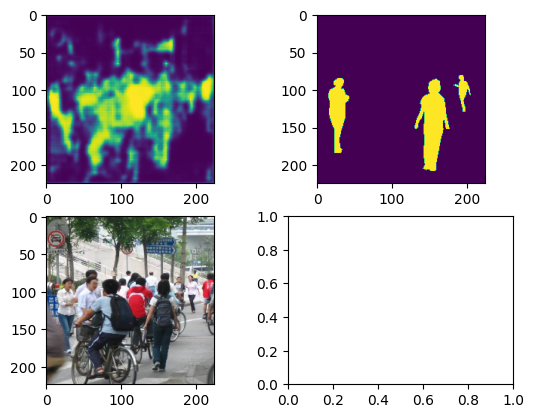

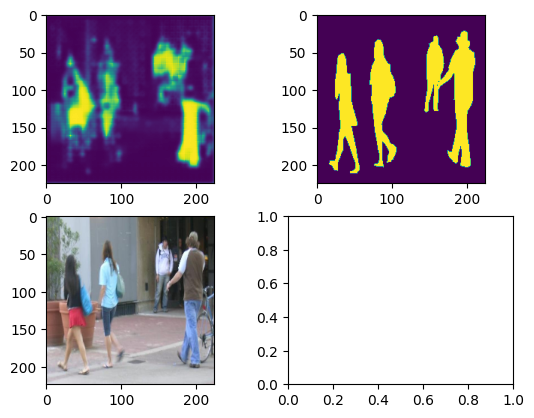

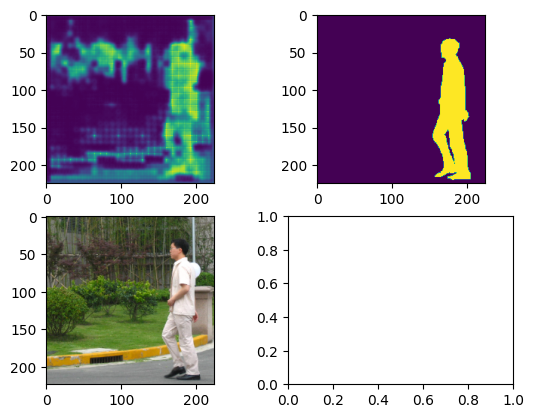

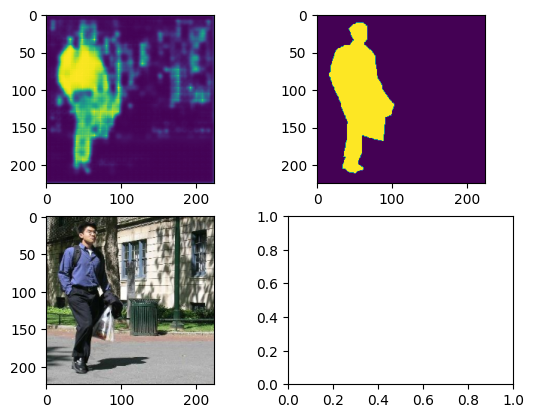

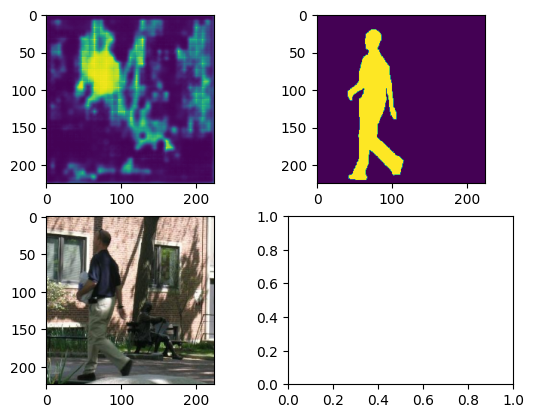

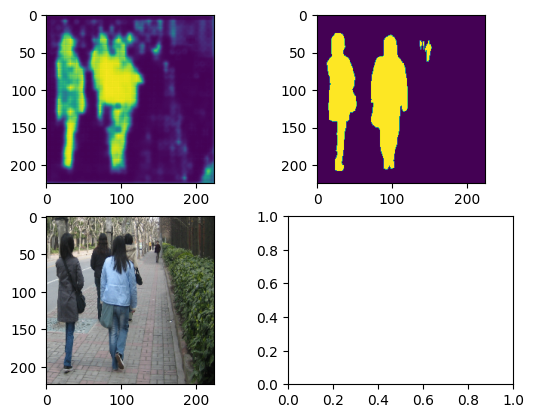

In [327]:
with torch.no_grad():
    for i, (image_batch, target_batch) in enumerate(data_loader_test):
        combined_input = []
        combined_target = []
        for image in image_batch:
            combined_input.append(image)
        for target_dict in target_batch:
            target = target_dict["masks"].sum(dim=0).unsqueeze(0)
            combined_target.append(target)
        final_input = torch.stack(combined_input, dim=0).to(device)
        final_target = torch.stack(combined_target, dim=0).to(device)
        
        predicted = fcn_model(final_input)
        
        _, axarr = plt.subplots(2, 2)
        axarr[0, 0].imshow(predicted[0].cpu().permute(1, 2, 0))
        axarr[0, 1].imshow(target[0].cpu().unsqueeze(2))
        axarr[1, 0].imshow(final_input[0].cpu().permute(1, 2, 0))
#         print(target[0].cpu().shape)
        if i>=5:
            break